**import Required libraries :**


In [30]:
import cv2
import urllib.request
import matplotlib.pyplot as plt

In [31]:
# Create a background subtractor using the MOG2 method with shadow detection enabled.
bg_subtractor = cv2.createBackgroundSubtractorMOG2(detectShadows=True)

# Define the kernel sizes for erosion and dilation
erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

# URL to the raw video file on GitHub
video_url = "https://github.com/ZahraEk/OpenCV-Course/raw/main/videos/car_racing.mp4"

# Download the video
video_filename = "car_racing.mp4"
urllib.request.urlretrieve(video_url, video_filename)

# Open the video file for reading
cap = cv2.VideoCapture(video_filename)

# Initialize a video capture
#cap = cv2.VideoCapture(0)
      
# Capture a frame from the camera
success, frame = cap.read()
while success:
    
    # Apply background subtraction to get the foreground mask
    fg_mask = bg_subtractor.apply(frame)

    # Apply thresholding to create a binary image
    _, thresh = cv2.threshold(fg_mask, 244, 255, cv2.THRESH_BINARY)

    # Apply morphological erosion and dilation to smoothen the thresholded image
    cv2.erode(thresh, erode_kernel, thresh, iterations=2)
    cv2.dilate(thresh, dilate_kernel, thresh, iterations=2)

    # Find contours of objects in the thresholded image
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop through detected contours and draw bounding rectangles for large ones
    for c in contours:
        if cv2.contourArea(c) > 1000:
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
    cv2.imshow('MOG', fg_mask)
    cv2.imshow('Thresh', thresh)
    cv2.imshow('Detection', frame)

    k = cv2.waitKey(1)
    if k == 27:  # Escape
        break

    # Capture a frame from the camera
    success, frame = cap.read()

# Release the video capture object and close OpenCV windows
cap.release()
cv2.destroyAllWindows()

In [32]:
cap = cv2.VideoCapture(video_filename)

# Capture 20 frames to allow the camera's autoexposure to adjust.
for i in range(20):
    success, frame = cap.read()
if not success:
    exit(1)

# Define an initial tracking window for a specific object.
frame_h, frame_w = frame.shape[:2]
w = frame_w // 3  # Adjust the width of the window
h = frame_h // 5  # Adjust the height of the window
x = 10  # Adjust the x-coordinate of the top-left corner of the window
y = 400  # Adjust the y-coordinate of the top-left corner of the window
track_window = (x, y, w, h)

roi = frame[y:y+h, x:x+w]

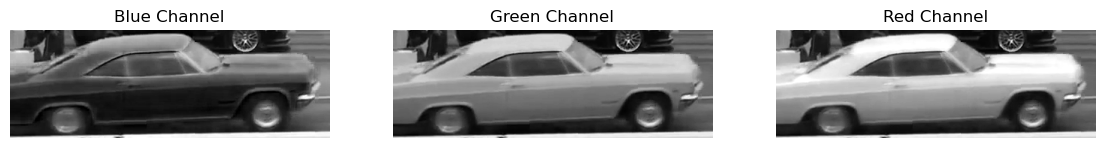

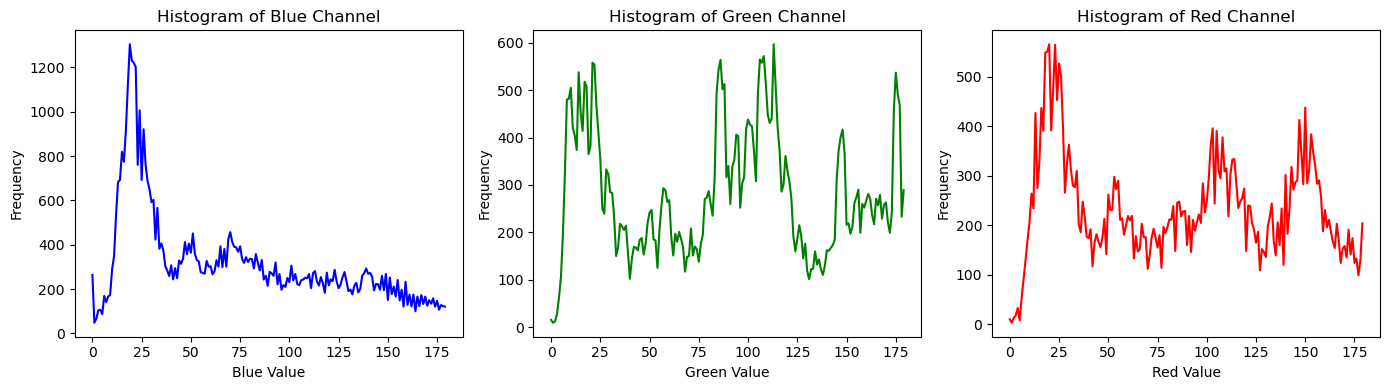

In [33]:
# Splitting the image into R, G, and B channels
b, g, r = cv2.split(roi)

# Displaying the channels
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.imshow(b, cmap='gray')
plt.title('Blue Channel')
plt.axis('off')

plt.subplot(132)
plt.imshow(g, cmap='gray')
plt.title('Green Channel')
plt.axis('off')

plt.subplot(133)
plt.imshow(r, cmap='gray')
plt.title('Red Channel')
plt.axis('off')

plt.show()

# Define a mask (optional, currently set to None)
mask = None

# Calculating histograms for the R, G, and B channels
b_hist = cv2.calcHist([roi], [0], mask, [180], [0, 180])
g_hist = cv2.calcHist([roi], [1], mask, [180], [0, 180])
r_hist = cv2.calcHist([roi], [2], mask, [180], [0, 180])

# Displaying the histograms of the channels
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(b_hist, color='b')
plt.title('Histogram of Blue Channel')
plt.xlabel('Blue Value')
plt.ylabel('Frequency') 

plt.subplot(132)
plt.plot(g_hist, color='g')
plt.title('Histogram of Green Channel')
plt.xlabel('Green Value')
plt.ylabel('Frequency')

plt.subplot(133)
plt.plot(r_hist, color='r')
plt.title('Histogram of Red Channel')
plt.xlabel('Red Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

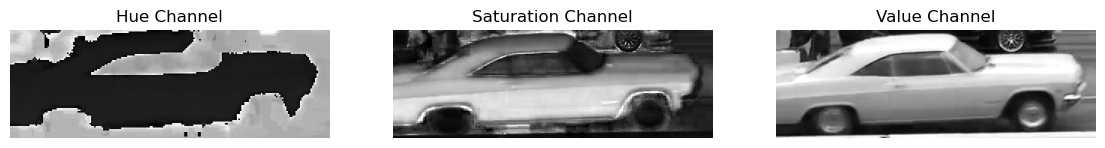

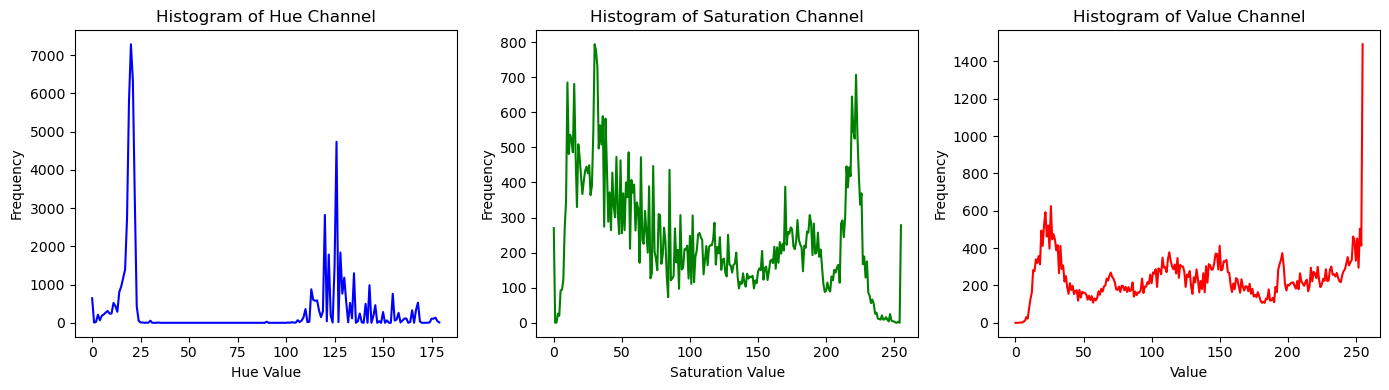

In [34]:
# Convert ROI to HSV color space
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# Split the HSV image into H, S, and V channels
h, s, v = cv2.split(hsv_roi)

# Display the channels
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.imshow(h, cmap='gray')
plt.title('Hue Channel')
plt.axis('off')

plt.subplot(132)
plt.imshow(s, cmap='gray')
plt.title('Saturation Channel')
plt.axis('off')

plt.subplot(133)
plt.imshow(v, cmap='gray')
plt.title('Value Channel')
plt.axis('off')

plt.show()

# Define a mask (optional, currently set to None)
mask = None

# Calculate histograms for the H, S, and V channels
h_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
s_hist = cv2.calcHist([hsv_roi], [1], mask, [256], [0, 256])
v_hist = cv2.calcHist([hsv_roi], [2], mask, [256], [0, 256])

# Display the histograms
plt.figure(figsize=(14, 4))

plt.subplot(131)
plt.plot(h_hist, color='b')
plt.title('Histogram of Hue Channel')
plt.xlabel('Hue Value')
plt.ylabel('Frequency') 

plt.subplot(132)
plt.plot(s_hist, color='g')
plt.title('Histogram of Saturation Channel')
plt.xlabel('Saturation Value')
plt.ylabel('Frequency')

plt.subplot(133)
plt.plot(v_hist, color='r')
plt.title('Histogram of Value Channel')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [35]:
# Calculate the normalized HSV histogram of the initial window.
h_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
cv2.normalize(h_hist, h_hist, 0, 255, cv2.NORM_MINMAX)

# Define the termination criteria:
# 10 iterations or convergence within 1-pixel radius.
term_crit = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 10, 1)

# Capture a frame from the camera
success, frame = cap.read()
while success:
    
    # if frame is read correctly ret is True
    if not success:
        print("Can't receive frame (stream end?). Exiting ...")
        break
        
    # Perform back-projection of the HSV histogram onto the frame.
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    back_proj = cv2.calcBackProject([hsv], [0], h_hist, [0, 180], 1)

    # Perform tracking with MeanShift.
    num_iters, track_window = cv2.meanShift(back_proj, track_window, term_crit)

    # Draw the tracking window.
    x, y, w, h = track_window
    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
    
    # Display the resulting frame
    cv2.imshow('back-projection', back_proj)
    cv2.imshow('meanshift', frame)

    k = cv2.waitKey(30)
    if k == 27:  # Escape
        break
        
    # Capture a frame from the camera
    success, frame = cap.read()
    
# Release the video capture object and close OpenCV windows
cap.release()
cv2.destroyAllWindows()